# Arbol de Decisión: ¿Quién llegará al número uno en Billboard 100?

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

 ## Cargamos los datos de entrada 



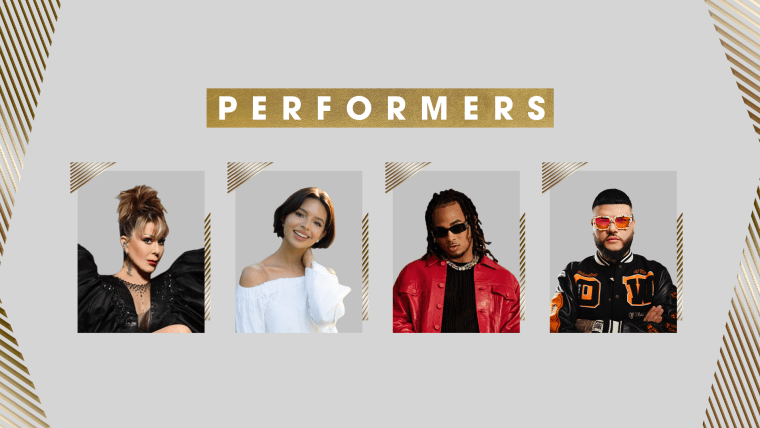

In [2]:
artists_billboard = pd.read_csv('artists_billboard_fix3.csv')

In [3]:
artists_billboard.shape

(635, 11)

In [4]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


mood:  
Brooding
Energizing
Excited
Brooding
Yearning
Upbeat


estado animico:  
1 melancólico
2 Energizante
3 emocionado
4 melancólico
5 anhelo
6 optimista

## ¿Cuántos alcanzaron el número 1?

In [5]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

Es decir que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad DESBALANCEADA de etiquetas con 1 y 0. Lo tendremos en cuenta al momento de crear el árbol.

Veamo una grafica de los artistas que han alacanzado el numero 1 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


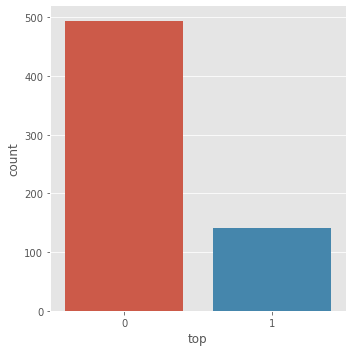

In [6]:
sb.factorplot('top', data=artists_billboard, kind='count')

Veamos cuántos registros hay de tipo de artista, “mood”, tempo y género de las canciones:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


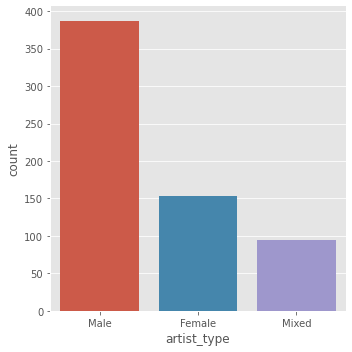

In [7]:
sb.factorplot('artist_type', data=artists_billboard, kind='count')

Aqui vemos que tenemos más del doble de artistas masculinos que femeninos y unos 100 registros de canciones mixtas

## Visualicemos los Atributos de entrada

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


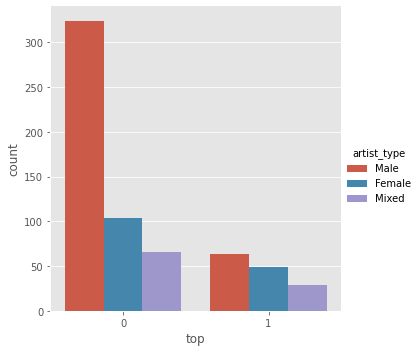

In [8]:
sb.factorplot('top', data=artists_billboard,hue='artist_type', kind='count')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


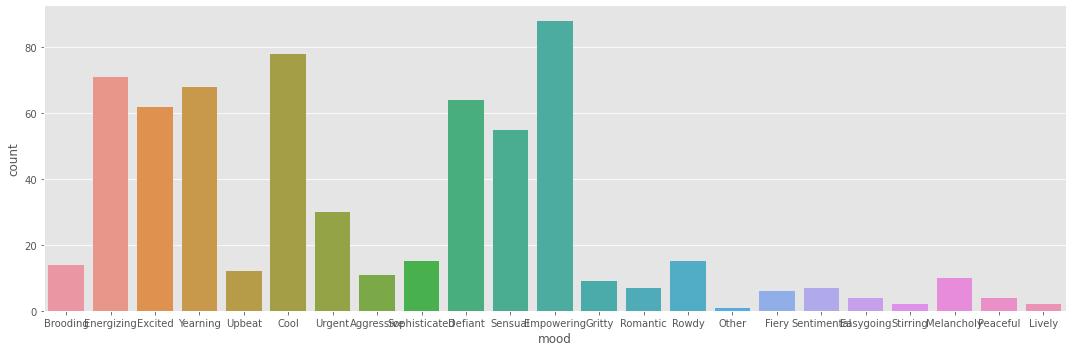

In [9]:
sb.factorplot('mood', data=artists_billboard, kind='count', aspect=3)

Vemos que de 23 tipos de Mood, destacan 7 con picos altos. Además notamos que algunos estados de ánimo son similares

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


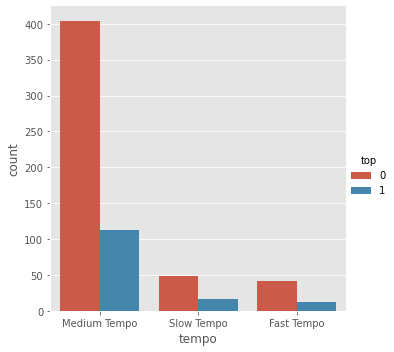

In [10]:
sb.factorplot('tempo', data=artists_billboard, hue='top', kind='count')

En esta gráfica vemos que hay 3 tipos de Tempo: Medium, Slow y Fast. Evidentemente predominan los tiempos Medium y también es donde encontramos más canciones que hayan alcanzado el Top 1 (en azul)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


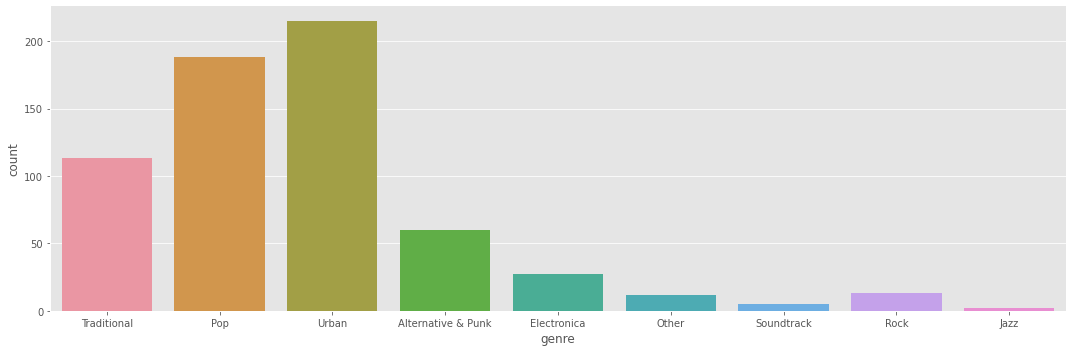

In [11]:
sb.factorplot('genre', data=artists_billboard, kind='count', aspect=3)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


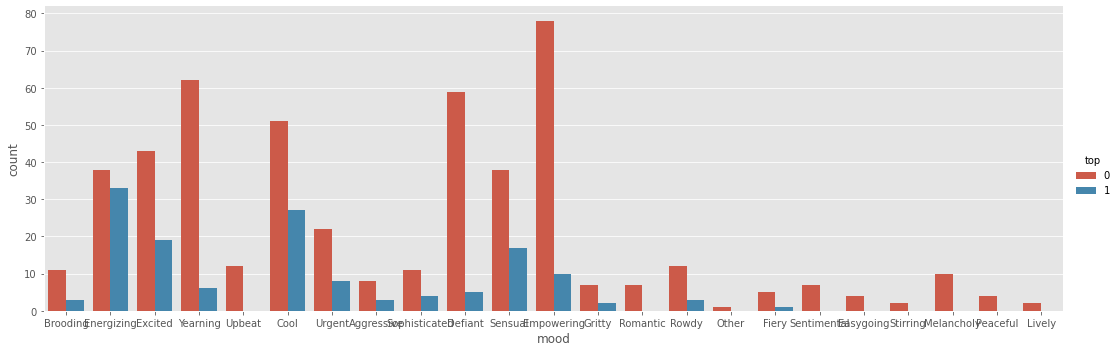

In [12]:
sb.factorplot('mood', data=artists_billboard, hue='top', kind='count', aspect=3)

### Visualizamos los años de nacimiento de los artistas

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


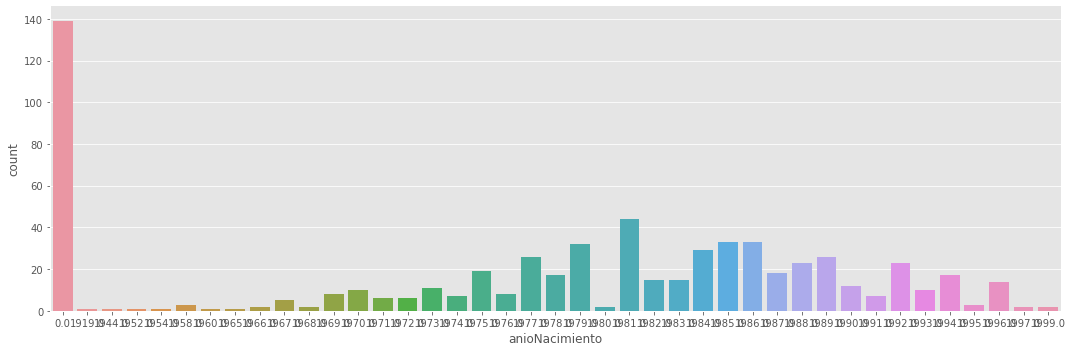

In [13]:
sb.factorplot('anioNacimiento', data=artists_billboard, kind='count', aspect=3)

Aqui notamos algo raro: en el año “cero” tenemos cerca de 139 registros…

In [14]:
#artists_billboard[['anioNacimiento', 'top']].groupby(['anioNacimiento'], as_index=False).agg(['mean', 'count', 'sum'])
nacimientoPorAnio=artists_billboard['anioNacimiento']
len(nacimientoPorAnio[nacimientoPorAnio<=0])

139

Notamos que tenemos 139 registros de canciones de las que desconocemos el año de nacimiento del artista.  
El resto de años parecen concentrarse entre 1979 y 1994.    
Deberemos tratar estos datos para poder utilizar el árbol.

# Comparemos los Top y los No-top

### Buscamos si hay alguna relación evidente entre Año y duración de Canción

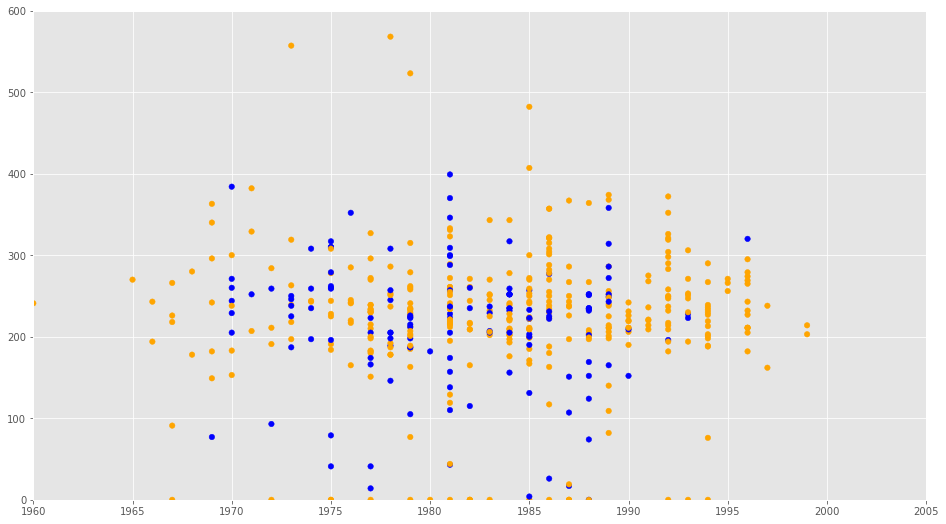

In [15]:
colores=['orange','blue']
tamanios=[60,40]

f1=artists_billboard['anioNacimiento'].values
f2=artists_billboard['durationSeg'].values

asignar=[]
for index, row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])
    
plt.scatter(f1,f2, c=asignar, s=30)
plt.axis([1960,2005,0,600])
plt.show()

No perece haber ningún patron a la vista, están bastante mezclados los top de los no-top.

Esto es porque inicialmente tomé información de 2014 y 2015 y había casi 500 no-top contra sólo 11 registros top.
Entonces tomé a los artistas que alcanzaron el top entre 2004 y 2013 para sumar casos positivos y equilibrar un poco nuestros datos de entrada. Así y todo, sigue estando desbalanceado.

## Arreglar las Edades de Artistas

In [16]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

In [17]:
#cuando es el año de lazamiento de la canciòn
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4] # obten solo el año 
    if anio==0.0: #anio nace el artista
        return None # regresa vacio
    return int(momento) - anio

artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

In [18]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,NaN


### Calculamos promedio de edad y asignamos a los registros Nulos

In [19]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum() # suma edades vacias
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
#age_null_random_list trae un rango de edade aleatorias

#Obtenemos los valore vacio
conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int) # lo pase a enteros
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


### Visualizamos las edades que agregamos

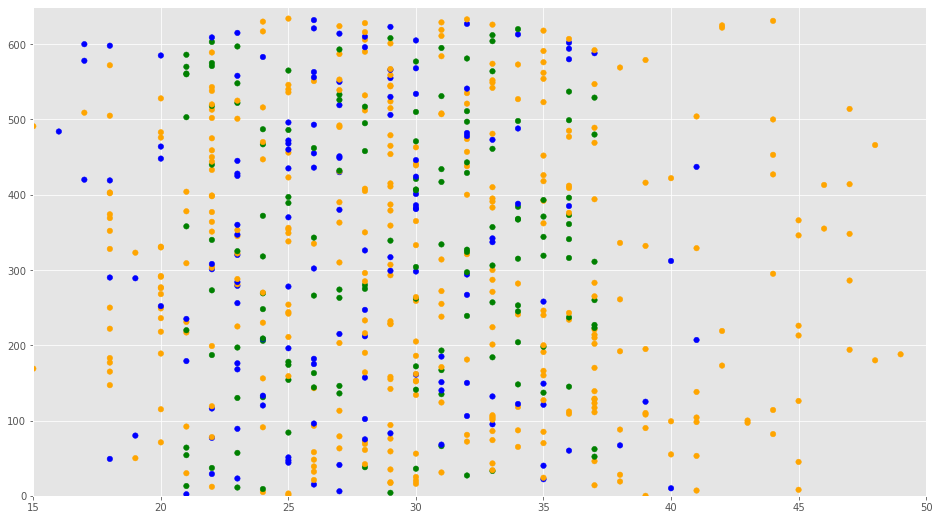

In [20]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange','blue','green']

asignar=[]
for index, row in artists_billboard.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

# Mapeo de Atributos

Realizaremos un mapeo de los atributos de entrada para poder transformarlos a categorias que podamos utilzar en nuestro árbol de decisión 

In [21]:
separador = "### ### ###"
grouped11 = artists_billboard.groupby('mood').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)
print(separador)
print("Tiempos de Canción: " + str(artists_billboard['tempo'].unique()))
print(separador)
print("Tipos de Artista: " + str(artists_billboard['artist_type'].unique()))
print(separador)
grouped11 = artists_billboard.groupby('genre').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)

mood
Empowering       88
Cool             78
Energizing       71
Yearning         68
Defiant          64
Excited          62
Sensual          55
Urgent           30
Rowdy            15
Sophisticated    15
Brooding         14
Upbeat           12
Aggressive       11
Melancholy       10
Gritty            9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64
### ### ###
Tiempos de Canción: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo']
### ### ###
Tipos de Artista: ['Male' 'Female' 'Mixed']
### ### ###
genre
Urban                 215
Pop                   188
Traditional           113
Alternative & Punk     60
Electronica            27
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64


In [22]:
# Mood Mapping 
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping 
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 
                                                        2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping 
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)
# artist_type Mapping 
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)


# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

Eliminamos columnas originales y usamos las del papeo

In [23]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

# Analizamos nuestros datos de Entrada Categóricos

In [24]:
artists_encoded.head(20)

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,4,2,2,3,3.0,2.0
1,0,6,2,3,2,1.0,6.0
2,1,5,2,4,1,0.0,3.0
3,0,4,2,1,3,1.0,2.0
4,0,4,2,2,2,2.0,3.0
5,0,5,2,2,3,1.0,3.0
6,1,5,1,4,2,2.0,0.0
7,0,3,0,3,3,4.0,6.0
8,0,4,2,4,2,4.0,2.0
9,0,4,2,1,3,1.0,6.0


In [25]:
artists_encoded.describe()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.222047,4.344882,1.730709,2.755906,2.459843,2.031496,3.179528
std,0.415950,1.350003,0.603553,1.165463,0.740583,1.151991,1.775017
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,4.000000,2.000000,3.000000,3.000000,2.000000,3.000000
75%,0.000000,5.500000,2.000000,4.000000,3.000000,3.000000,4.000000
max,1.000000,6.000000,2.000000,4.000000,3.000000,4.000000,6.000000


<AxesSubplot:title={'center':'Correlación de características de Pearson'}>

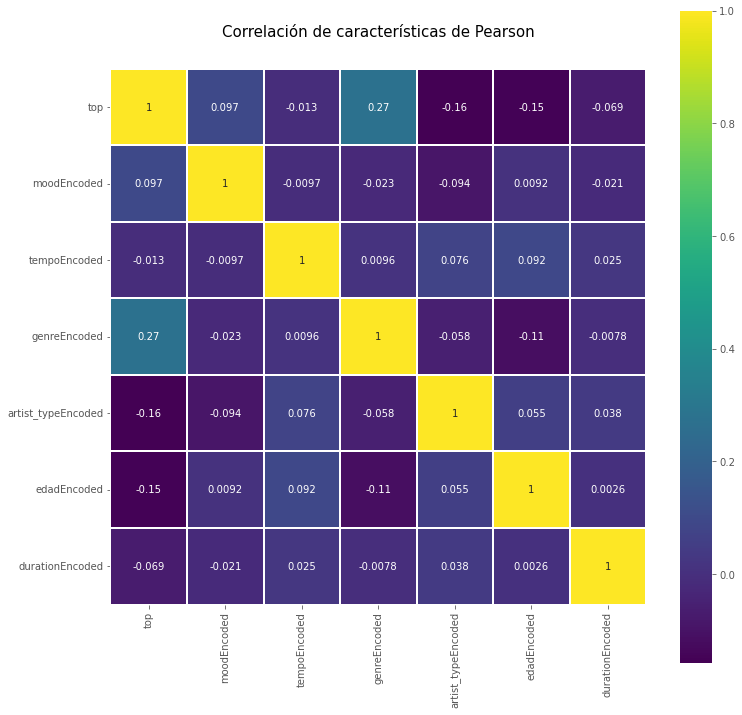

In [26]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlación de características de Pearson', y=1.05, size=15)
sb.heatmap(artists_encoded.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [27]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

In [28]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

In [29]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

In [30]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

In [31]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

In [32]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

In [33]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
edadEncoded                    
0.0          0.242857    70  17
1.0          0.311688   154  48
2.0          0.256944   144  37
3.0          0.168182   220  37
4.0          0.042553    47   2

# Creamos el Arbol de Decisión

In [34]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values

#crear el arbol de decision con profundidad=4
#Que vamos hacer 4 preguntas a los datos
decision_tree = tree.DecisionTreeClassifier(
                                            criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5, # Minimo de datos por hoja
                                            max_depth=4, #profundidad
                                            class_weight={1:3.5}
                                           )
#Hacen el modelo de entrenamiento
decision_tree.fit(x_train, y_train) 

DecisionTreeClassifier(class_weight={1: 3.5}, criterion='entropy', max_depth=4,
                       min_samples_leaf=5, min_samples_split=20)

In [35]:
#vamos a ver lo que hizo el algoritmo
with open("arbol.dot",'w') as f:
    f = tree.export_graphviz(
                             decision_tree,
                             out_file=f,
                             max_depth=7,
                             impurity=True,
                            feature_names=list(artists_encoded.drop(['top'], axis=1)),
                            class_names=['No', 'N1 Billboard'],
                            rounded=True,
                            filled=True
                            )

In [36]:
# Convertir el archivo .dot a png para poder visualizarlo
#check_call(['dot','-Tpng',r'arbol.dot','-o',r'arbol.png'])
#PImage("arbol.png")

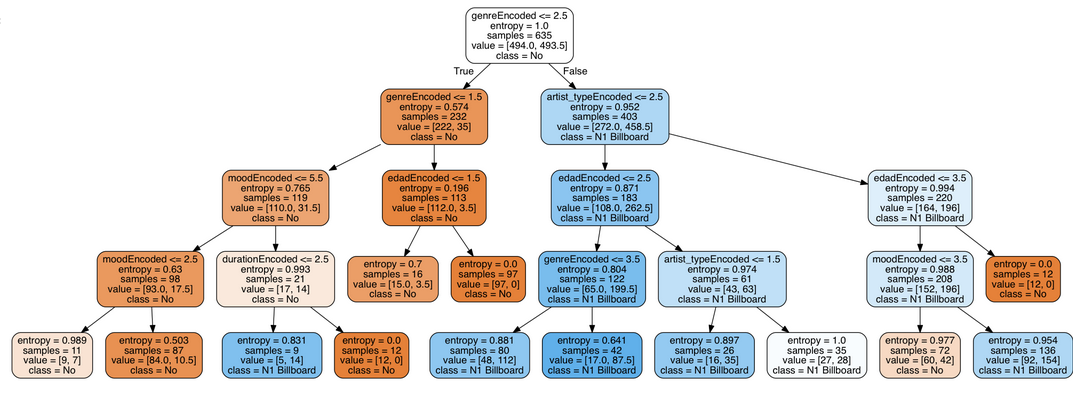

#vamos a ver lo que hizo el algoritmo
with open("arbol.dot",'w') as f:
    f = tree.export_graphviz(
                             decision_tree,
                             out_file=f,
                             max_depth=7,
                             impurity=True,
                            feature_names=list(artists_encoded.drop(['top'], axis=1)),
                            class_names=['No', 'N1 Billboard'],
                            rounded=True,
                            filled=True
                            )

## Precisión del árbol

In [37]:
acc_decision_tree = round(decision_tree.score(x_train,y_train) * 100,2)
print(acc_decision_tree)

68.19


# Predicción del árbol de decisión

In [39]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017
x_test = pd.DataFrame(columns=('top', 'moodEncoded', 'tempoEncoded','genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))

x_test.loc[0]=(1,5,2,4,1,0,3)

y_pred = decision_tree.predict(x_test.drop(['top'], axis=1))

print("Prediccion:" + str(y_pred))
y_probabilidad= decision_tree.predict_proba(x_test.drop(['top'], axis=1))

print("Probabilidad de Acierto" + str(round(y_probabilidad[0][y_pred][0]* 100,2))+"%")


Prediccion:[1]
Probabilidad de Acierto71.43%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [40]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017
x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 88.89%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
